In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import warnings
warnings.simplefilter('ignore')

In [2]:
equity = "HDFCBANK.NS"
start_date = "2013-07-06"
end_date = "2023-07-06"
equity_data = yf.download(equity, start=start_date, end=end_date, progress=False)

In [3]:
equity_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2464 entries, 2013-07-08 to 2023-07-05
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2464 non-null   float64
 1   High       2464 non-null   float64
 2   Low        2464 non-null   float64
 3   Close      2464 non-null   float64
 4   Adj Close  2464 non-null   float64
 5   Volume     2464 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 134.8 KB


In [4]:
equity_data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2464.000000,2464.000000,2464.000000,2464.000000,2464.000000,2.464000e+03
mean,959.056940,967.824887,949.608696,958.895871,928.521910,6.521975e+06
std,422.772412,426.529529,418.854607,422.653283,422.570735,6.777056e+06
min,277.850006,286.000000,264.000000,280.950012,261.230103,0.000000e+00
25%,539.250000,543.437500,534.250000,539.850021,508.957359,2.813840e+06
50%,974.975006,982.924988,963.700012,974.125000,938.028625,4.792492e+06
75%,1359.925018,1371.487488,1343.949982,1356.062500,1334.893585,7.903996e+06
max,1723.449951,1757.500000,1713.800049,1728.199951,1728.199951,2.011300e+08


In [5]:
def calculate_keltner_channel_bands(data, ema_period=20, atr_period=10, multiplier=2):
    
    """
    Calculate the upper and lower bands of the Keltner Channel based on the given data.

    Args:
        data (pandas.DataFrame): Dataframe containing the necessary columns 'Close', 'High', and 'Low'.
        ema_period (int): Period for the Exponential Moving Average (EMA) calculation. Default is 20.
        atr_period (int): Period for the Average True Range (ATR) calculation. Default is 10.
        multiplier (float): Multiplier for calculating the distance between the bands and the EMA. Default is 2.

    Returns:
        tuple: A tuple containing three pandas.Series objects representing the EMA, upper band, and lower band, respectively.
    """
    
    # Exponential Moving Average (EMA)
    ema = data['Close'].ewm(span=ema_period, adjust=False).mean()

    #Average True Range (ATR)
    high_low = data['High'] - data['Low']
    high_close = np.abs(data['High'] - data['Close'].shift())
    low_close = np.abs(data['Low'] - data['Close'].shift())
    true_range = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    atr = true_range.rolling(atr_period).mean()

    #Keltner Channel
    upper_band = ema + (multiplier * atr)
    lower_band = ema - (multiplier * atr)

    return ema, upper_band, lower_band


In [6]:
start_date = pd.to_datetime(start_date)
end_date = pd.to_datetime(end_date)

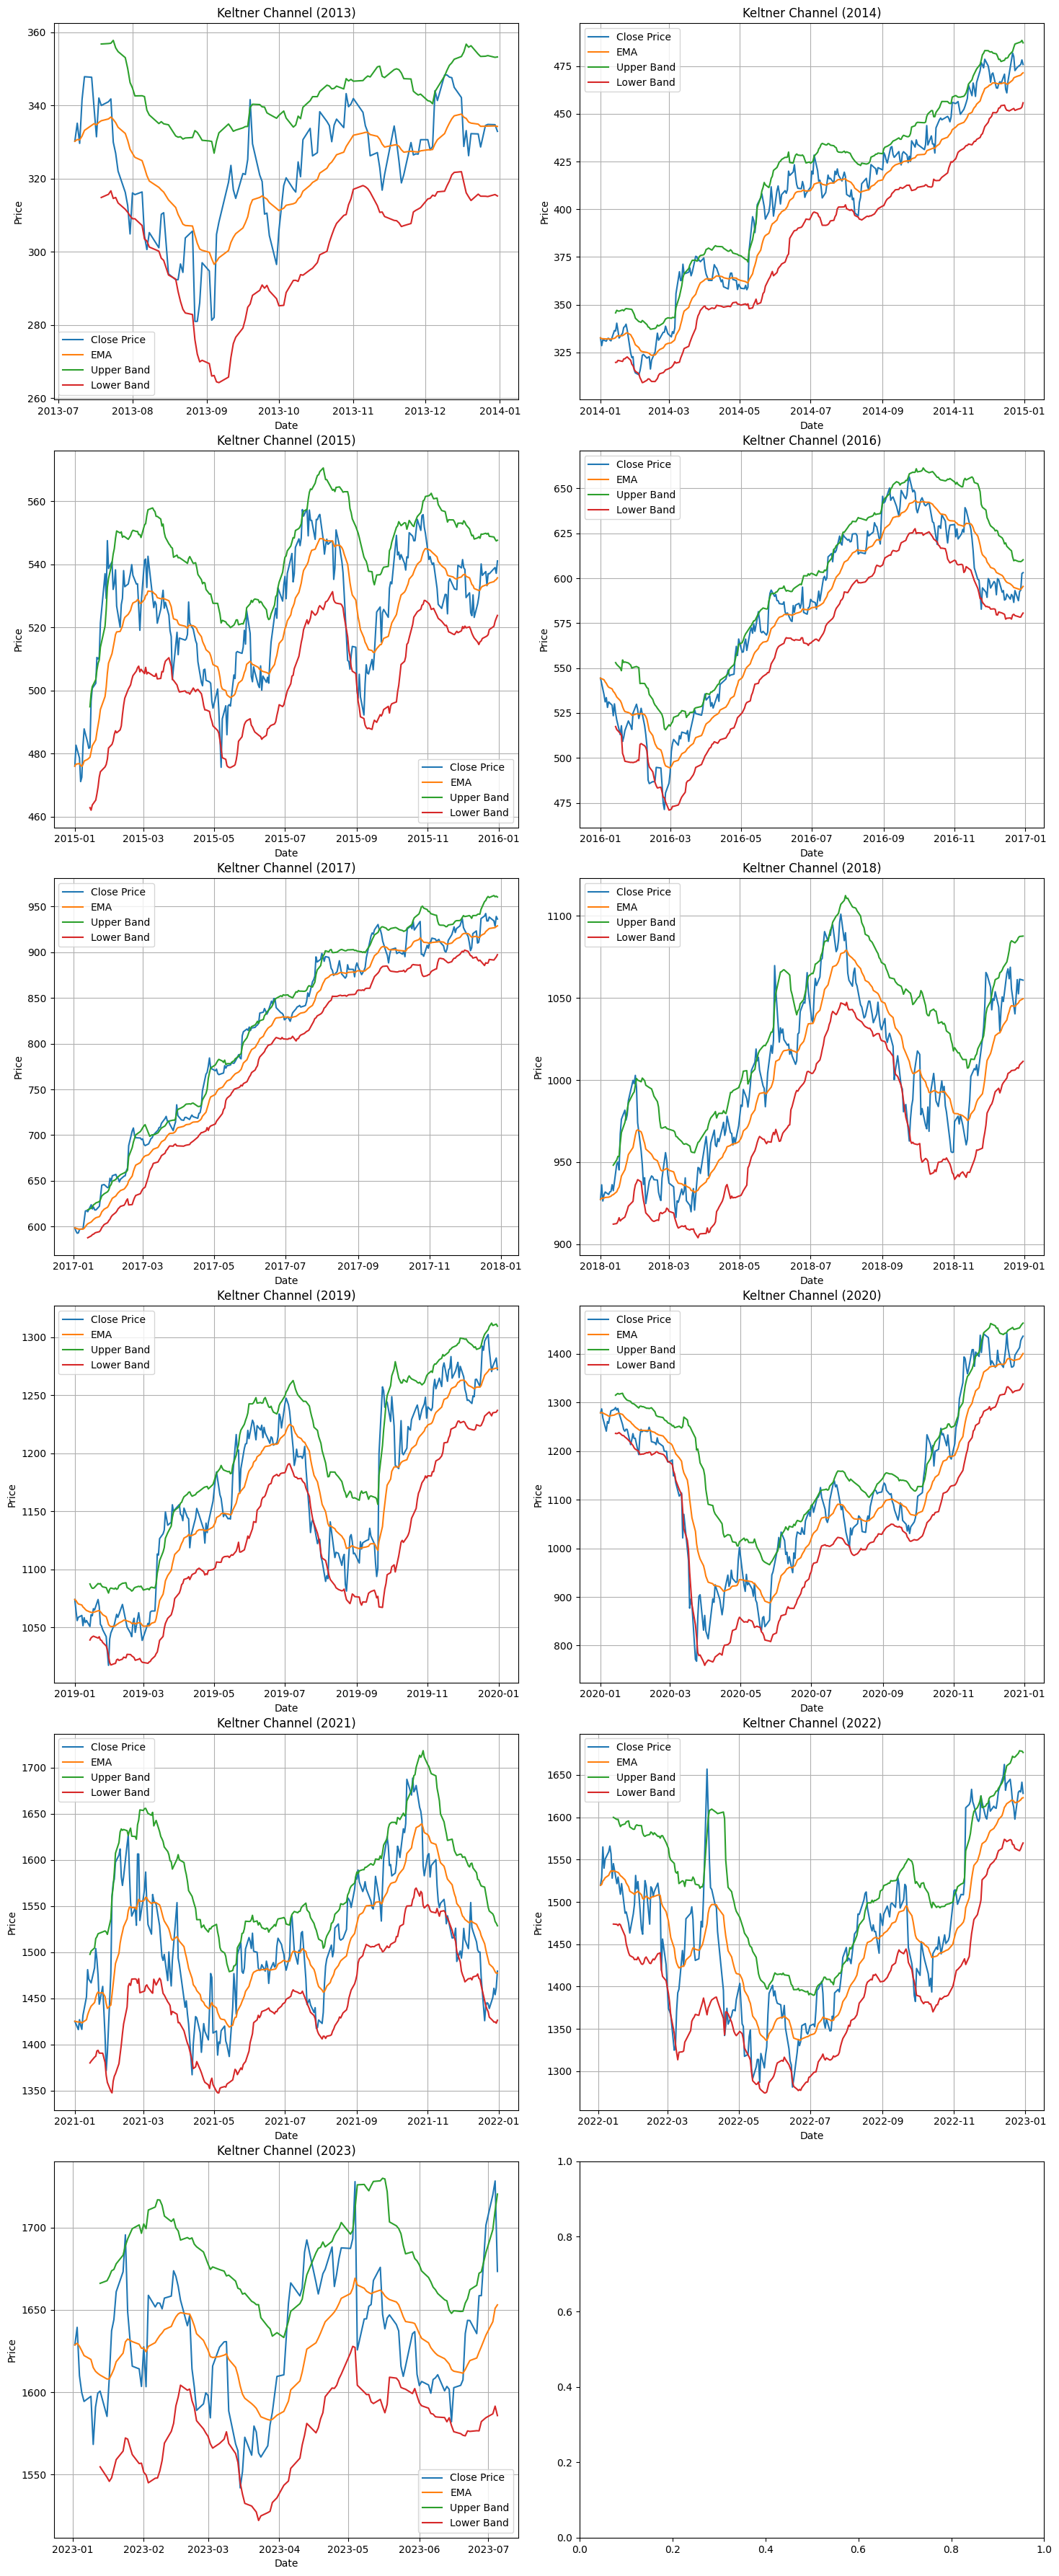

In [7]:
start_year = start_date.year
end_year = end_date.year
total_years = end_year - start_year + 1

# Calculate the number of rows and columns for the subplot grid
num_rows = (total_years + 1) // 2
num_cols = 2

fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 6*num_rows))
fig.tight_layout(pad=3.0)

for i, year in enumerate(range(start_year, end_year + 1)):
    year_data = equity_data[str(year)]
    ema, upper_band, lower_band = calculate_keltner_channel_bands(year_data)

    # Calculate subplot position
    row = i // num_cols
    col = i % num_cols

    # Plotting
    axs[row, col].plot(year_data.index, year_data['Close'], label='Close Price')
    axs[row, col].plot(year_data.index, ema, label='EMA')
    axs[row, col].plot(year_data.index, upper_band, label='Upper Band')
    axs[row, col].plot(year_data.index, lower_band, label='Lower Band')
    axs[row, col].set_title('Keltner Channel ({0})'.format(year))
    axs[row, col].set_xlabel('Date')
    axs[row, col].set_ylabel('Price')
    axs[row, col].legend()
    axs[row, col].grid(True)

plt.show()

The graph graph can be explained as when the closing price consistently reaches or exceeds the upper band, it may suggest an overbought condition, indicating a potential reversal or correction. Conversely, when the closing price consistently falls below the lower band, it may indicate an oversold condition, signaling a potential bounce or upward move.

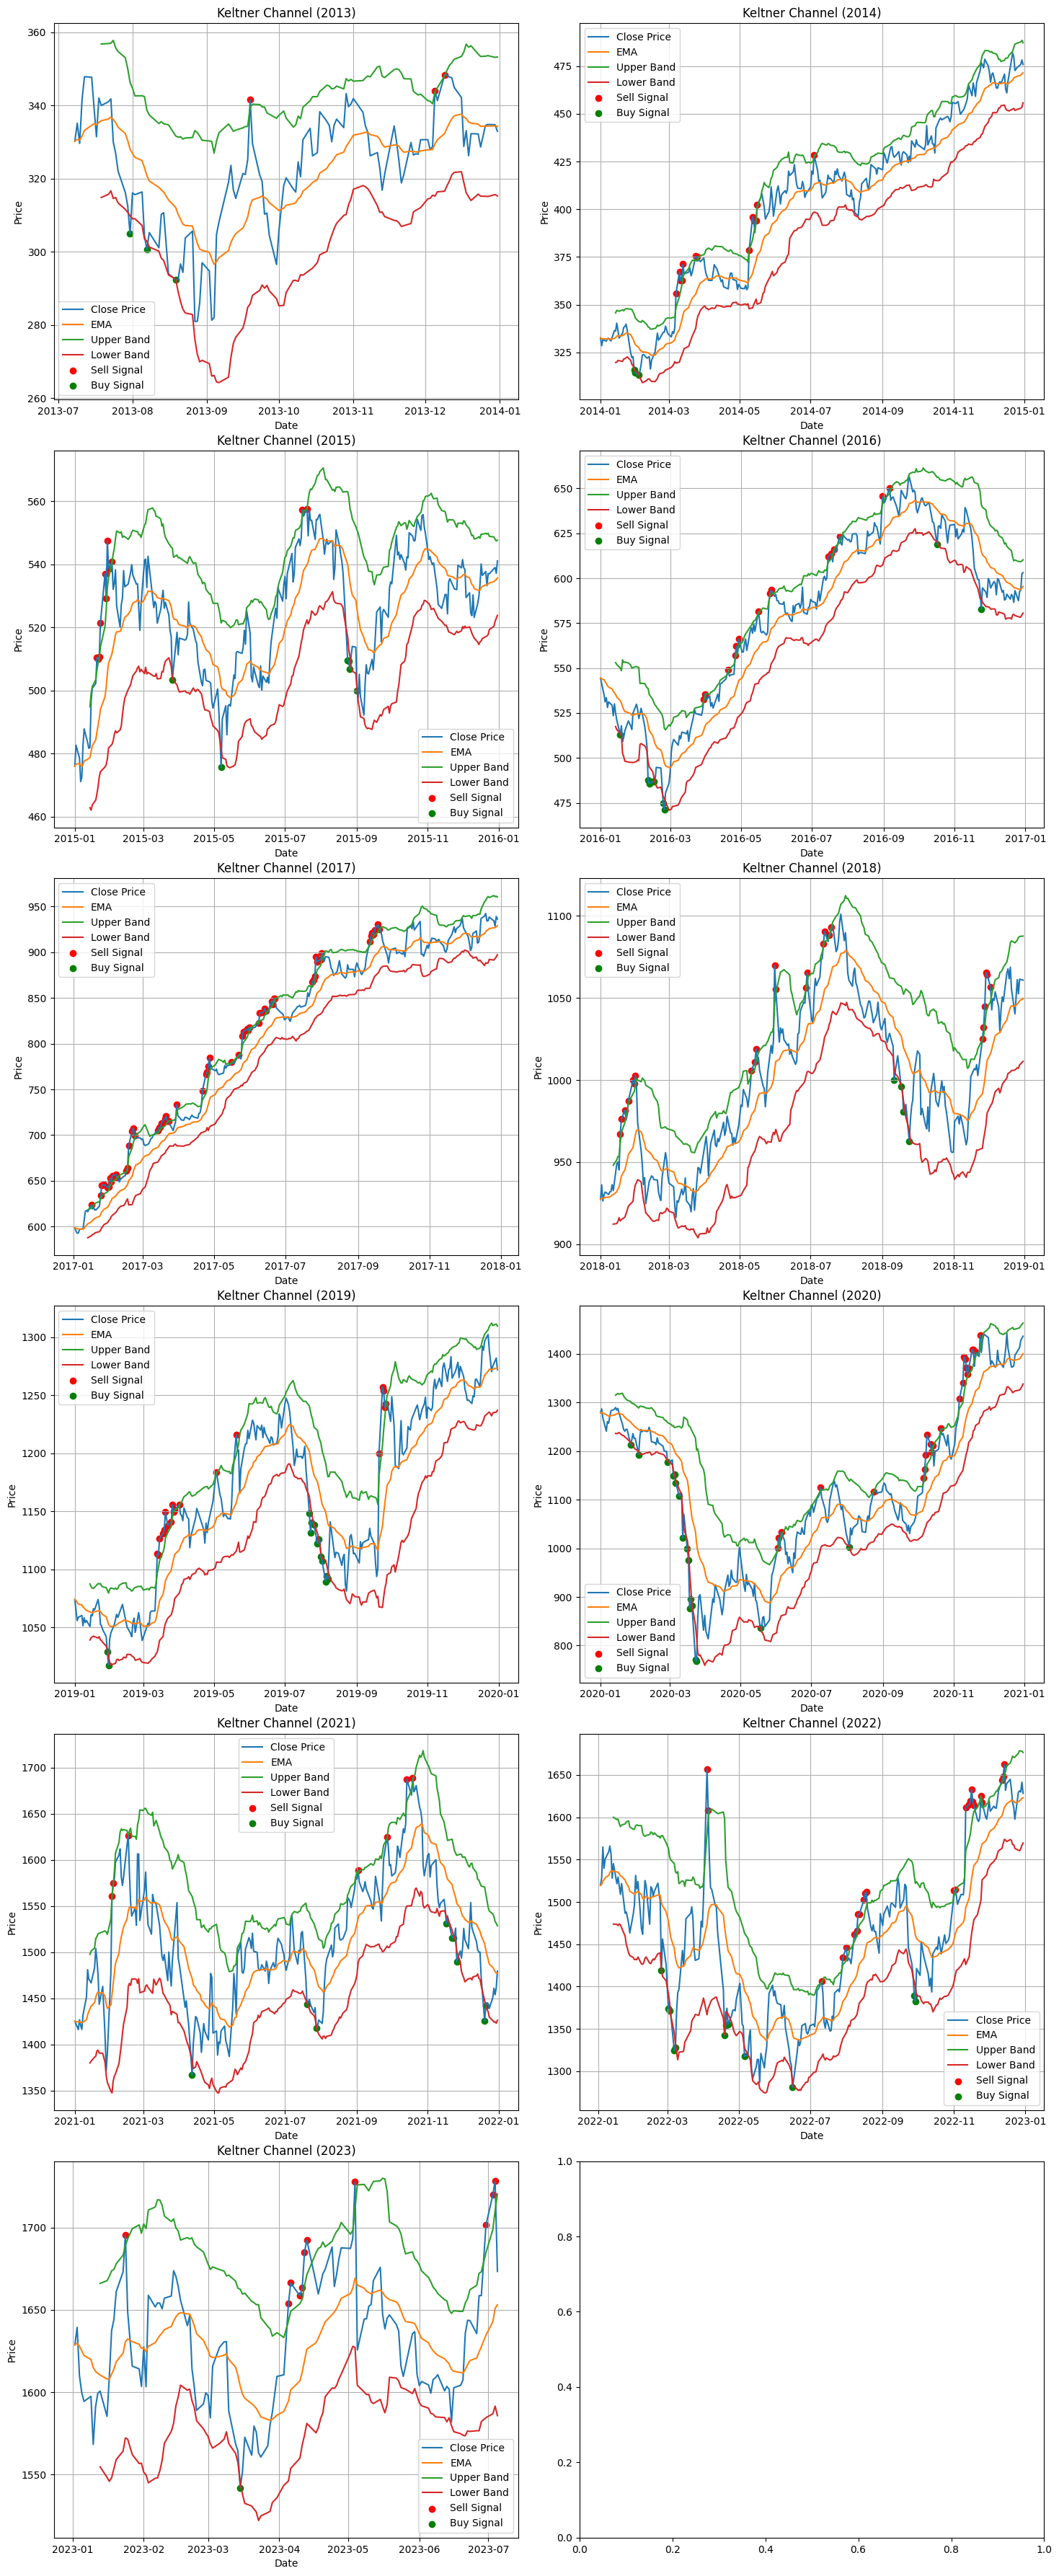

In [8]:
start_year = start_date.year
end_year = end_date.year
total_years = end_year - start_year + 1

# Calculate the number of rows and columns for the subplot grid
num_rows = (total_years + 1) // 2
num_cols = 2

fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 6*num_rows))
fig.tight_layout(pad=3.0)

for i, year in enumerate(range(start_year, end_year + 1)):
    year_data = equity_data[str(year)]
    ema, upper_band, lower_band = calculate_keltner_channel_bands(year_data)

    # Here we are generating sell and buy signals
    sell_signals = year_data[year_data['Close'] > upper_band]['Close']
    buy_signals = year_data[year_data['Close'] < lower_band]['Close']

    # Calculate subplot position
    row = i // num_cols
    col = i % num_cols

    # Plotting
    axs[row, col].plot(year_data.index, year_data['Close'], label='Close Price')
    axs[row, col].plot(year_data.index, ema, label='EMA')
    axs[row, col].plot(year_data.index, upper_band, label='Upper Band')
    axs[row, col].plot(year_data.index, lower_band, label='Lower Band')
    axs[row, col].scatter(sell_signals.index, sell_signals, color='red', label='Sell Signal', marker='o')
    axs[row, col].scatter(buy_signals.index, buy_signals, color='green', label='Buy Signal', marker='o')
    axs[row, col].set_title('Keltner Channel ({0})'.format(year))
    axs[row, col].set_xlabel('Date')
    axs[row, col].set_ylabel('Price')
    axs[row, col].legend()
    axs[row, col].grid(True)

plt.show()

### Trading Strategy:
* If the price is below the lower line of the Keltner Channel, it indicates a potential buying opportunity.
* If the price is above the upper line of the Keltner Channel, it suggests a potential selling opportunity.

In [10]:
import matplotlib.pyplot as plt
import plotly.graph_objects as go

ModuleNotFoundError: No module named 'plotly'

In [ ]:
start_year = start_date.year
end_year = end_date.year
total_years = end_year - start_year + 1

# Calculate the number of rows and columns for the subplot grid
num_rows = (total_years + 1) // 2
num_cols = 2

for i, year in enumerate(range(start_year, end_year + 1)):
    year_data = equity_data[str(year)]

    # Preparing data for candlestick plot
    candlestick = go.Candlestick(
        x=year_data.index,
        open=year_data['Open'],
        high=year_data['High'],
        low=year_data['Low'],
        close=year_data['Close']
    )

    # Calculate subplot position
    row = i // num_cols
    col = i % num_cols

    # Plotting
    layout = go.Layout(
        title='Candlestick Chart ({0})'.format(year),
        xaxis=dict(title='Date'),
        yaxis=dict(title='Price'),
        showlegend=False
    )
    fig = go.Figure(data=[candlestick], layout=layout)
    fig.update_layout(height=400, width=1500)  # Set the desired chart size
    fig.show()

In [ ]:
for year in range(start_date.year, end_date.year + 1):
    year_data = equity_data[str(year)]
    ema, upper_band, lower_band = calculate_keltner_channel_bands(year_data)

    # Here we are preparing data for candlestick plot
    candlestick = go.Candlestick(
        x=year_data.index,
        open=year_data['Open'],
        high=year_data['High'],
        low=year_data['Low'],
        close=year_data['Close']
    )

    #Here we are plotting
    fig = go.Figure()

    # Here we are adding candlestick trace
    fig.add_trace(candlestick)

    # Here we are adding Keltner Channel lines
    fig.add_trace(go.Scatter(
        x=year_data.index, y=ema,
        mode='lines',
        name='EMA',
        line=dict(color='blue')
    ))
    fig.add_trace(go.Scatter(
        x=year_data.index, y=upper_band,
        mode='lines',
        name='Upper Band',
        line=dict(color='orange')
    ))
    fig.add_trace(go.Scatter(
        x=year_data.index, y=lower_band,
        mode='lines',
        name='Lower Band',
        line=dict(color='orange')
    ))

    # Here we are setting layout
    fig.update_layout(
        title='Keltner Channel and Candlestick Chart ({0})'.format(year),
        xaxis=dict(title='Date'),
        yaxis=dict(title='Price')
    )

    # Show the combined plot
    fig.show()

In [ ]:
start_date = pd.to_datetime("2013-07-05")
end_date = pd.to_datetime("2023-07-05")

for year in range(start_date.year, end_date.year + 1):
    year_data = equity_data[str(year)]
    ema, upper_band, lower_band = calculate_keltner_channel_bands(year_data)

    # Here we are preparing data for candlestick plot
    candlestick = go.Candlestick(
        x=year_data.index,
        open=year_data['Open'],
        high=year_data['High'],
        low=year_data['Low'],
        close=year_data['Close']
    )

    # Here we are plotting
    fig = go.Figure()

    # Here we are adding candlestick trace
    fig.add_trace(candlestick)

    # Here we are adding Keltner Channel lines
    fig.add_trace(go.Scatter(
        x=year_data.index, y=ema,
        mode='lines',
        name='EMA',
        line=dict(color='blue')
    ))
    fig.add_trace(go.Scatter(
        x=year_data.index, y=upper_band,
        mode='lines',
        name='Upper Band',
        line=dict(color='orange')
    ))
    fig.add_trace(go.Scatter(
        x=year_data.index, y=lower_band,
        mode='lines',
        name='Lower Band',
        line=dict(color='orange')
    ))

    # Here we are finding hammer candlestick pattern
    hammer_pattern = year_data[(year_data['Low'] - year_data['Open']) > 2 * (year_data['Close'] - year_data['Open'])]

    # Here we are generating buy and sell signals
    buy_signals = hammer_pattern['High'] + 0.01
    sell_signals = hammer_pattern['Low'] - 0.01

    # Here we are plotting buy signals
    fig.add_trace(go.Scatter(
        x=hammer_pattern.index,
        y=buy_signals,
        mode='markers',
        marker=dict(symbol="cross", color="green"),
        name='Buy Signals'
    ))

    # Here we are plotting sell signals
    fig.add_trace(go.Scatter(
        x=hammer_pattern.index,
        y=sell_signals,
        mode='markers',
        marker=dict(symbol="cross", color="red"),
        name='Sell Signals'
    ))

    # Here we are setting layout
    fig.update_layout(
        title='Keltner Channel and Candlestick Chart ({0})'.format(year),
        xaxis=dict(title='Date'),
        yaxis=dict(title='Price'),
        showlegend=True
    )

    fig.show()

### Finding relevant statistics for the strategy: 

In [ ]:
cumulative_returns = []
max_drawdowns = []
sharpe_ratios = []

In [ ]:
#Returns, Drawdown, and Sharpe Ratio
returns = (hammer_pattern['Close'].pct_change() + 1).cumprod()
cumulative_returns.append(returns[-1] - 1)

# Drawdown
equity_curve = returns.cumprod()
previous_peaks = equity_curve.cummax()
drawdowns = (equity_curve - previous_peaks) / previous_peaks
max_drawdowns.append(drawdowns.max())

# Sharpe Ratio
daily_returns = hammer_pattern['Close'].pct_change()
sharpe_ratio = (daily_returns.mean() / daily_returns.std()) * np.sqrt(252)
sharpe_ratios.append(sharpe_ratio)

In [ ]:
mean_cumulative_returns = np.mean(cumulative_returns)
mean_max_drawdowns = np.mean(max_drawdowns)
mean_sharpe_ratios = np.mean(sharpe_ratios)

In [ ]:
print("Mean Cumulative Returns: ", mean_cumulative_returns)
print("Mean Maximum Drawdowns: ", mean_max_drawdowns)
print("Mean Sharpe Ratios: ", mean_sharpe_ratios)